# DAT200 CA5 2022

Kaggle username: Tage Andersen

### Imports

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

### Reading data

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

del train['Unnamed: 0'] # Deleting unnecessary column
del test['Unnamed: 0']

### Data exploration and visualisation

In [8]:
# Display the first few rows of the dataset
print(train.head())

# Print the summary statistics of the dataset
print(train.describe())

# Print the data types of the columns in the dataset
print(train.dtypes)

   Capsaicin level  Pungent odor  Vitamin C  Water  Light transmittance  \
0            166.7           6.8        0.0  77.95                 32.4   
1            170.4           5.7        0.0  74.06                 39.0   
2            212.5           3.1        0.0  88.27                 22.4   
3            216.0           1.0        0.0  80.01                 22.4   
4            146.5           1.3      141.0  78.64                 28.8   

   Temp storage  Time storage  Dihydrocapsaicin level  Fibre density  \
0           7.5           4.0                    32.4          13.56   
1           4.7          52.0                    47.1           8.58   
2           5.9           1.0                   161.7          13.57   
3           6.4          31.0                    10.2          21.27   
4           4.6          38.0                    20.7           5.83   

   Protein density  Saturated fatty acids  Monounsaturated fatty acids  \
0             1.05                  24.47 

### Visualizing before cleaning

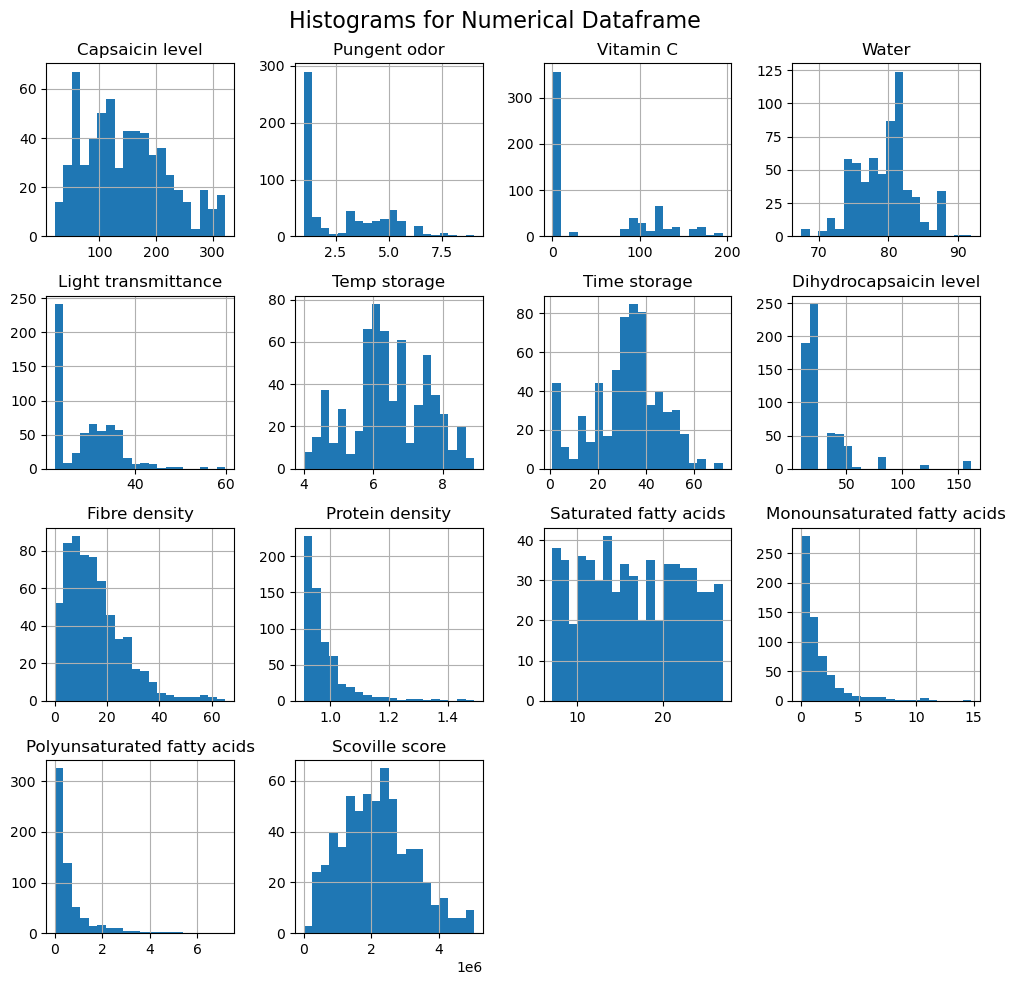

Text(0.5, 1.0, 'Violin plot')

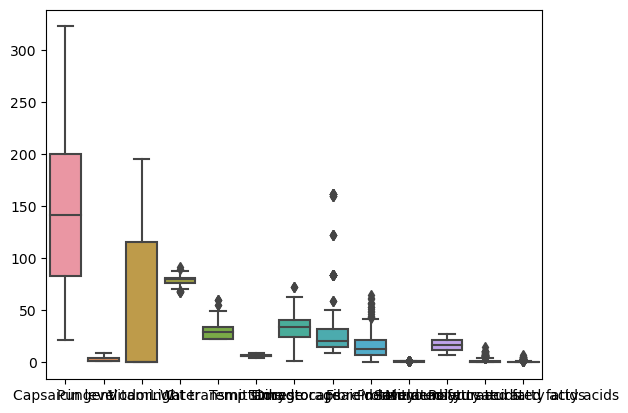

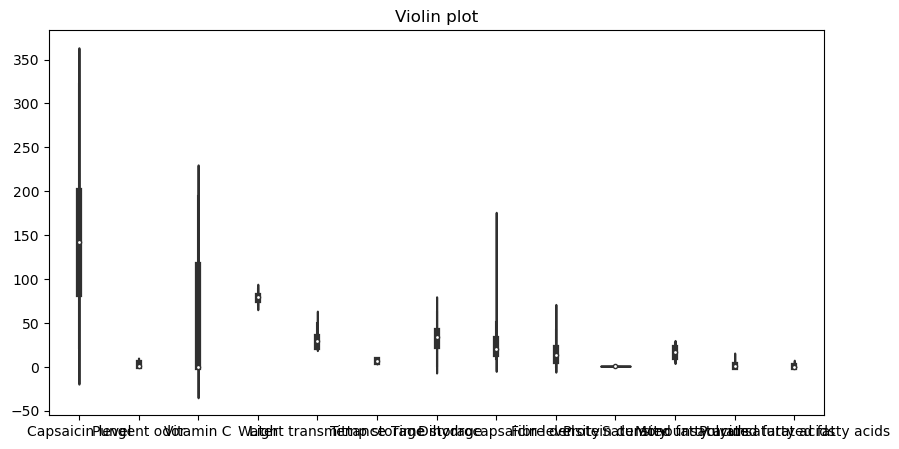

In [9]:
train.hist(bins=20, figsize=(10, 10))
plt.suptitle("Histograms for Numerical Dataframe", fontsize=16)
plt.tight_layout()
plt.show()

sns.boxplot(data=train.iloc[:, :-1]) 

plt.figure(figsize=(10, 5))
sns.violinplot(data=train.iloc[:, :-1],
            rotation=45,
            dodge=True,   # separate plots of different colors
            width=0.5,    # width of plots
            palette = "bright"
       )

plt.title("Violin plot")

### Data cleaning

In [10]:
# Calculate the IQR for each column in the dataset:
Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1

# Define a threshold to identify outlier:
threshold = 1.5

train_clean = train.copy()
for col in train_clean.columns:
    lower_bound = Q1[col] - threshold * IQR[col]
    upper_bound = Q3[col] + threshold * IQR[col]
    train_clean[col] = train_clean[col].apply(lambda x: x if lower_bound <= x <= upper_bound else np.nan)

train_clean = train_clean.dropna(axis=0)  # remove rows with NaN values

### Data preprocessing

In [11]:
# Separating features and target variable
X = train_clean.iloc[:, :-1]
y = train_clean.iloc[:, -1]

# Splitting dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Create a scaler object
scaler = StandardScaler()

# Fit the scaler object on the training data
X_train_sc = scaler.fit(X_train)

# Transform the training and test data using the scaler object
X_train_normalized = pd.DataFrame(scaler.transform(X_train))
X_test_normalized = pd.DataFrame(scaler.transform(X_test))

### Data exploration after cleaning

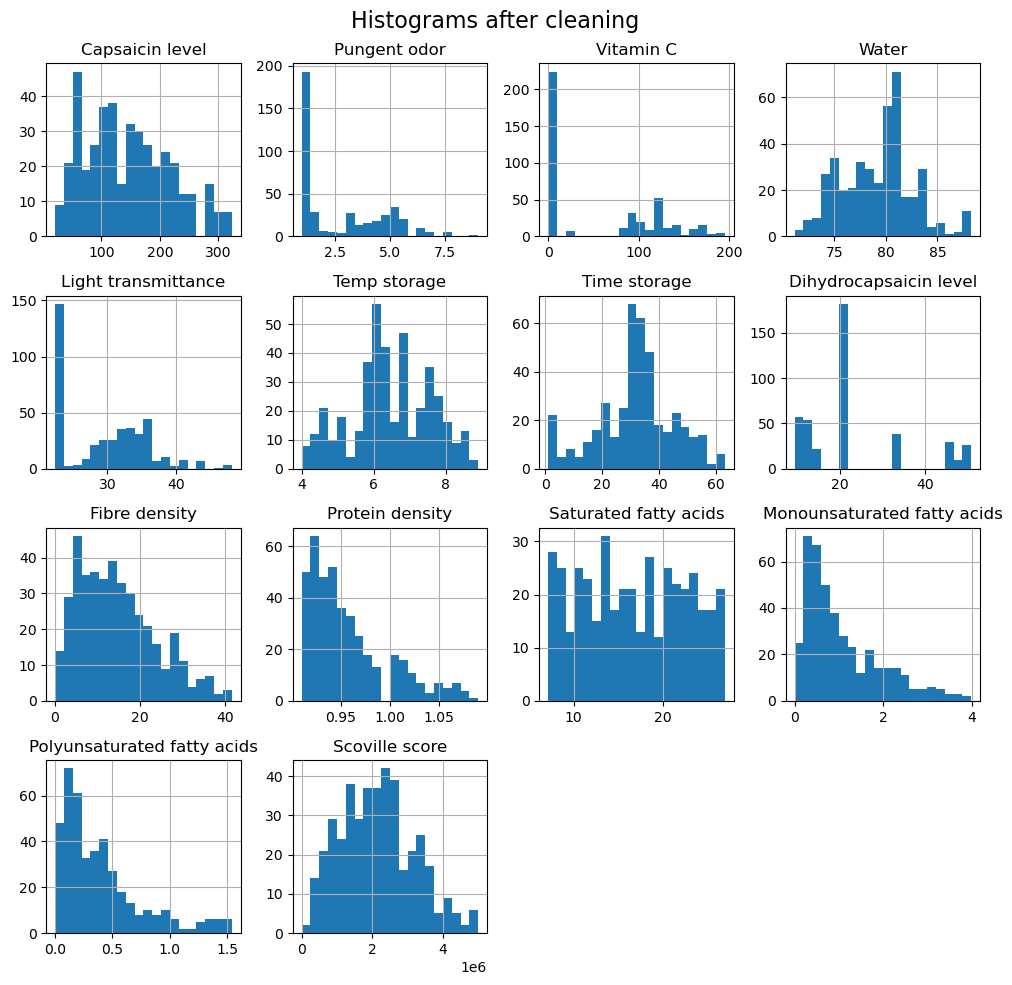

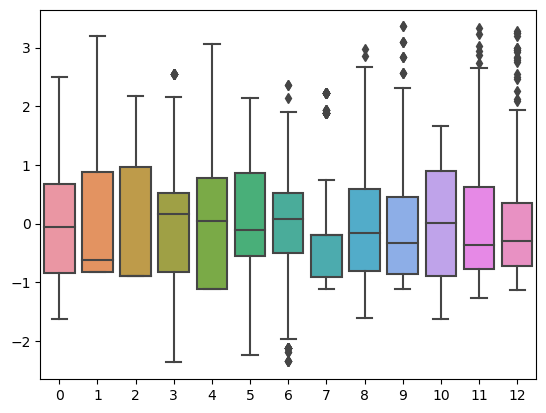

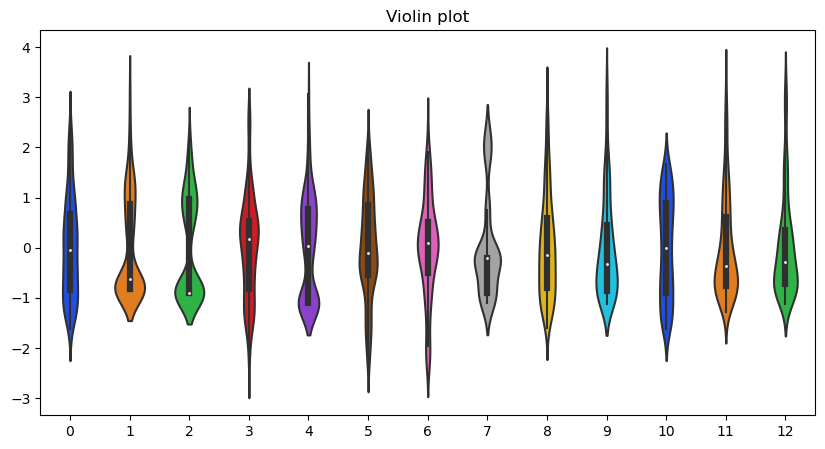

In [20]:
train_clean.hist(bins=20, figsize=(10, 10))
plt.suptitle("Histograms after cleaning", fontsize=16)
plt.tight_layout()
plt.show()

sns.boxplot(data=X_train_normalized) 

plt.figure(figsize=(10, 5))
sns.violinplot(data=X_train_normalized,
            rotation=45,
            dodge=True,   # separate plots of different colors
            width=0.5,    # width of plots
            palette = "bright"
       )

plt.title("Violin plot")
plt.show()

### Modelling

#### Data pipeline with classification model

In [13]:
#%%

# Transform target values into categorical labels using qcut
bins_train = pd.qcut(y_train, q=5, labels=False)
bins_test = pd.qcut(y_test, q=5, labels=False)

# Train an ensemble classification model on the categorical data
clf = RandomForestClassifier(n_estimators=100, max_depth=5)
clf.fit(X_train_normalized, bins_train)
predicted_bins_train = clf.predict(X_train_normalized)
predicted_bins_test = clf.predict(X_test_normalized)

# Evaluate the classification model
accuracy_train = accuracy_score(bins_train, predicted_bins_train)
accuracy_test = accuracy_score(bins_test, predicted_bins_test)
print('Classification accuracy on train set:', accuracy_train)
print('Classification accuracy on test set:', accuracy_test)

# Train a regression model on the original target values
reg = LinearRegression()
reg.fit(X_train_normalized, y_train)
predicted_target_train = reg.predict(X_train_normalized)
predicted_target_test = reg.predict(X_test_normalized)

# Evaluate the regression model
mse_train = mean_squared_error(y_train, predicted_target_train)
mse_test = mean_squared_error(y_test, predicted_target_test)
print('Mean squared error on train set:', mse_train)
print('Mean squared error on test set:', mse_test)

# Hyperparameter tuning for classification model
param_grid = {'n_estimators': [50, 100, 150, 200],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'criterion' :['gini', 'entropy']}

rf = RandomForestClassifier()
rf_grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
rf_grid_search.fit(X_train_normalized, bins_train)

# Print the best parameters and best score
print("Best Parameters for Random Forest Classification Model:", rf_grid_search.best_params_)
print("Best Score for Random Forest Classification Model:", rf_grid_search.best_score_)

# Define the grid of hyperparameters to search
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'max_features': ['sqrt', 'log2']
}

# Perform grid search cross-validation to find the optimal hyperparameters
rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=1),
                              param_grid=rf_param_grid,
                              cv=5,
                              scoring='accuracy',
                              n_jobs=-1)
rf_grid_search.fit(X_train_normalized, bins_train)

# Get the optimal hyperparameters
rf_best_params = rf_grid_search.best_params_
print('Random Forest best hyperparameters:', rf_best_params)

# Train a new model with the optimal hyperparameters
rf_clf = RandomForestClassifier(random_state=1, **rf_best_params)
rf_clf.fit(X_train_normalized, bins_train)

# Evaluate the model using accuracy score
rf_train_preds = rf_clf.predict(X_train_normalized)
rf_train_accuracy = accuracy_score(bins_train, rf_train_preds)
print('Random Forest training accuracy:', rf_train_accuracy)

# Evaluate the model using cross-validation
rf_cv_accuracy = np.mean(cross_val_score(rf_clf, X_train_normalized, bins_train, cv=5, scoring='accuracy'))
print('Random Forest CV accuracy:', rf_cv_accuracy)

# Train a regression model on the original target values
reg = LinearRegression()
reg.fit(X_train_normalized, y_train)
predicted_target = reg.predict(X_train_normalized)

# Evaluate the regression model
mae = mean_absolute_error(y_train, predicted_target)
print('Mean absolute error:', mae)


Classification accuracy on train set: 0.9221556886227545
Classification accuracy on test set: 0.5714285714285714
Mean squared error on train set: 248439752410.0447
Mean squared error on test set: 227209681619.4541
Best Parameters for Random Forest Classification Model: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}
Best Score for Random Forest Classification Model: 0.5718679330619629
Random Forest best hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Random Forest training accuracy: 1.0
Random Forest CV accuracy: 0.5629579375848033
Mean absolute error: 380647.300582257


Using more bins can capture more of the variation in the target variable and potentially improve the accuracy of the model. However, using too many bins can make the model more complex and prone to overfitting, resulting in lower overall performance.

#### Data pipeline with regression model

In [14]:
#%% Gradient Boosting Regressor with all features
# Train a regression model on the original target values
reg = GradientBoostingRegressor()
reg.fit(X_train_normalized, y_train)
predicted_target_train = reg.predict(X_train_normalized)
predicted_target_test = reg.predict(X_test_normalized)

# Evaluate the regression model
mse_train = mean_squared_error(y_train, predicted_target_train)
mse_test = mean_squared_error(y_test, predicted_target_test)
print('Mean squared error on train set:', mse_train)
print('Mean squared error on test set:', mse_test)

# Define the hyperparameters to tune
hyperparameters = {'n_estimators': [50, 100, 150], 
                   'learning_rate': [0.01, 0.1, 1], 
                   'max_depth': [3, 5, 7]}

# Create a Gradient Boosting Regressor model
model = GradientBoostingRegressor()

# Create a GridSearchCV object and fit it to the data
gb_grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring='neg_mean_squared_error')
gb_grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", gb_grid_search.best_params_)

# Get the best model
best_model = gb_grid_search.best_estimator_

# Evaluate the best model on the test data
test_score = best_model.score(X_test, y_test)
print("Test score with best model: ", test_score)

Mean squared error on train set: 32892743391.80953
Mean squared error on test set: 137568396825.3844
Best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
Test score with best model:  0.9040767365603022


##### Feature importance

In [15]:
# Get feature importances
feature_importances = best_model.feature_importances_

# Sort features by importance in descending order
indices = np.argsort(feature_importances)[::-1]

# Print feature importances in descending order
print("Feature importances:")
for f in range(X_train.shape[1]):
    print(f"{f+1}. {X_train.columns[indices[f]]}: {feature_importances[indices[f]]}")

Feature importances:
1. Dihydrocapsaicin level: 0.3603910586443183
2. Capsaicin level: 0.28140854738391813
3. Pungent odor: 0.10594126591099291
4. Water: 0.08683484125424161
5. Light transmittance: 0.06406623776644177
6. Time storage: 0.03426648834801123
7. Vitamin C: 0.022010540974318794
8. Temp storage: 0.01520915078163674
9. Fibre density: 0.007944897760573683
10. Saturated fatty acids: 0.007740287535566215
11. Monounsaturated fatty acids: 0.006626907218378412
12. Protein density: 0.005142715846211402
13. Polyunsaturated fatty acids: 0.0024170605753907745


#### Other models used for Kaggle submission

In [16]:
#%% Gradient Boosting Regressor w/ most important features

# Remove the features you want to exclude from the input dataframe
features_to_exclude = ['Polyunsaturated fatty acids', 'Protein density', 'Monounsaturated fatty acids', 'Saturated fatty acids', 'Fibre density', 'Temp storage', 'Vitamin C', 'Time storage']
X_train_new = X_train.drop(features_to_exclude, axis=1)
X_test_new = X_test.drop(features_to_exclude, axis=1)

# Train a regression model on the original target values
reg = GradientBoostingRegressor()
reg.fit(X_train_new, y_train)
predicted_target_train = reg.predict(X_train_new)
predicted_target_test = reg.predict(X_test_new)

# Evaluate the regression model
mse_train = mean_squared_error(y_train, predicted_target_train)
mse_test = mean_squared_error(y_test, predicted_target_test)
mea_train = mean_absolute_error(y_train, predicted_target_train)
mea_test = mean_absolute_error(y_test, predicted_target_test)
print('Mean squared error on train set:', mse_train)
print('Mean squared error on test set:', mse_test)
print('Mean absolute error on train set:', mea_train)
print('Mean absolute error on test set:', mea_test)

# Define the hyperparameters to tune
hyperparameters = {'n_estimators': [50, 100, 150], 
                   'learning_rate': [0.01, 0.1, 1], 
                   'max_depth': [3, 5, 7]}

# Create a Gradient Boosting Regressor model
model = GradientBoostingRegressor()

# Create a GridSearchCV object and fit it to the data
gb_best_grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring='neg_mean_squared_error')
gb_best_grid_search.fit(X_train_new, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", gb_best_grid_search.best_params_)

# Get the best model
best_model = gb_best_grid_search.best_estimator_

# Evaluate the best model on the test data
test_score = best_model.score(X_test_new, y_test)
print("Test score with best model: ", test_score)

Mean squared error on train set: 48133071765.25606
Mean squared error on test set: 128728457328.21696
Mean absolute error on train set: 164036.31480707176
Mean absolute error on test set: 284106.6677421191
Best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
Test score with best model:  0.9099093947647652


### Final Evaluation

In [17]:
# Predict the Scoville score on the test data using the best model
gb_reg = gb_grid_search.best_estimator_
gb_reg.fit(X_train, y_train)
pred = gb_reg.predict(test)
pred = pd.DataFrame(pred)
pred = (np.rint(pred)).astype(int)
csv = pred.to_csv('gb_prediction.csv', index_label='Id', header=['Scoville score'])

gb_best_reg = gb_best_grid_search.best_estimator_
gb_best_reg.fit(X_train_new, y_train)
pred = gb_best_reg.predict(test.drop(features_to_exclude, axis=1))
pred = pd.DataFrame(pred)
pred = (np.rint(pred)).astype(int)
csv = pred.to_csv('gb_best_prediction.csv', index_label='Id', header=['Scoville score'])


rf_kaggle = rf_grid_search.best_estimator_
rf_kaggle.fit(X_train, y_train)
pred = rf_kaggle.predict(test)
pred = pd.DataFrame(pred)
pred = (np.rint(pred)).astype(int)
csv = pred.to_csv('rf_prediction.csv', index_label='Id', header=['Scoville score'])

### Kaggle submission

In [19]:
gb_best_prediction = pd.read_csv("gb_best_prediction.csv")
gb_best_prediction

,Id,Scoville score
0,0,2511701
1,1,2445212
2,2,4407542
3,3,1952469
4,4,726021
...,...,...
407,407,1570081
408,408,741295
409,409,2180118
410,410,3893931
